# gpOptimizer: A Simple Black-Box Optimization

This is the new test for gpCAM version 8.1.3 and later.

In [4]:
##first install the right version of gpCAM
#!pip install gpcam==8.1.3

## Setup

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
import time


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data Prep

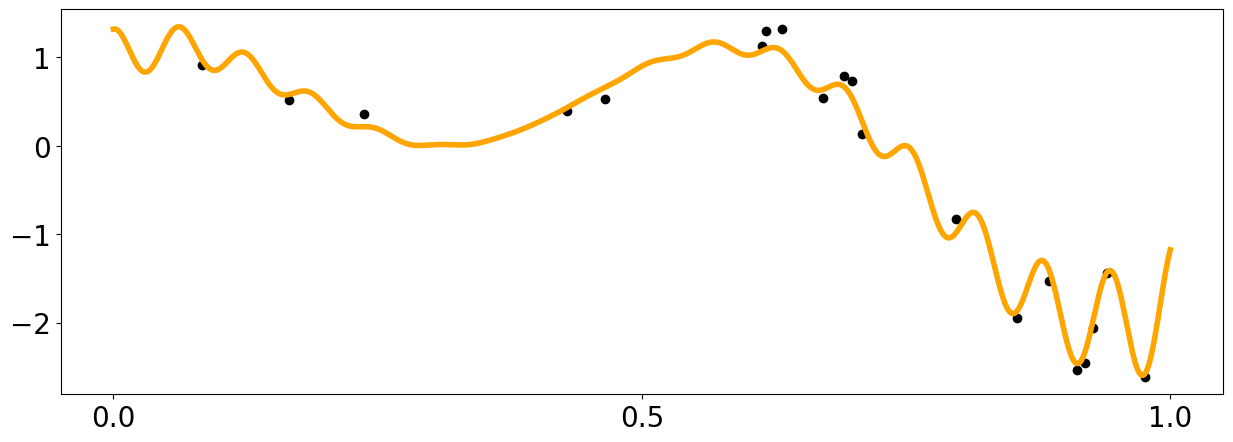

In [25]:
x = np.linspace(0,600,1000)
def f1(x):
    if np.ndim(x) == 1: return (np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)), np.zeros(len(x)) + 0.001
    else: return (np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x))[:,0], np.zeros(len(x)) + 0.001
 
x_data = np.random.rand(20).reshape(-1,1) 
y_data = f1(x_data[:,0])[0] + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D)[0], color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

## Customizing the Gaussian Process

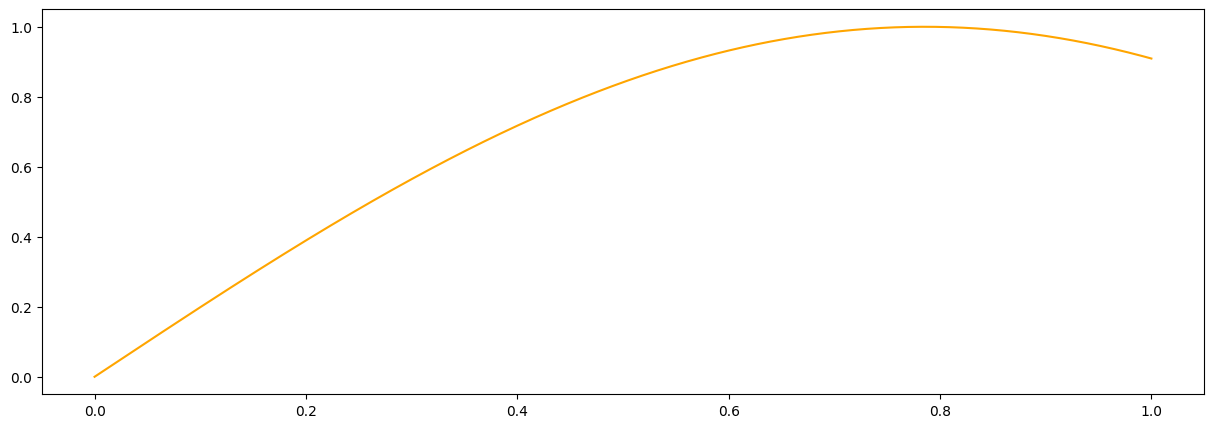

In [26]:
from gpcam.gp_kernels import *
def my_noise(x,hps):
    #This is a simple noise function, but can be arbitrarily complex using many hyperparameters.
    #The noise function always has to return a matrix, because the noise can have covariances.
    return np.diag(np.zeros((len(x))) + hps[2])

#stationary
def skernel(x1,x2,hps):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])


def meanf(x, hps):
    #This ios a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

## Initialization and Different Training Options

In [28]:


my_gp1 = GPOptimizer(
            init_hyperparameters = np.ones((4))/10.,  # We need enough of those for kernel, noise, and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.01, # providing noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            #gp_noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False, 
            args=None,
            )

hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,1.],  #noise
                       [0.01,1.]  #mean
                      ])


my_gp1.optimize(func=f1, search_space =  np.array([[0,1]]))


[[0.43614494]
 [0.63436803]
 [0.56118729]]
[0.47834695 1.05828841 1.15962846] [0.001 0.001 0.001]


/home/marcus/Coding/gpCAM/gpcam/gp_optimizer.py:301: UserWarning: You have not provided data yet. You have to manually initialize the GP before any class method can be used!
  warnings.warn("You have not provided data yet. You have to manually initialize the GP "


Exception: Please provide custom hyperparameter_bounds when kernel, mean or noise functions are customized

In [ ]:
my_gp1.get_data()

## Asynchronous Training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different trainings on different computers.
This training will continue without any signs of life until you call 'my_gp1.stop_training(opt_obj)'

In [ ]:
opt_obj = my_gp1.train_async(hyperparameter_bounds=hps_bounds)
for i in range(10):
    time.sleep(1)
    my_gp1.update_hyperparameters(opt_obj)
    print(my_gp1.get_hyperparameters())
    print("")
my_gp1.stop_training(opt_obj)

## Plotting the Result

In [ ]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gp1.rmse(x_pred1D,f1(x_pred1D)))
print(my_gp1.crps(x_pred1D,f1(x_pred1D)))

In [ ]:
#We can ask mutual information and total correlation there is given some test data
x_test = np.array([[0.45],[0.45]])
print("Mutual Information: ",my_gp1.gp_mutual_information(x_test))
print("Total Correlation : ",my_gp1.gp_total_correlation(x_test))

In [ ]:
next_point = my_gp1.ask(np.array([[0.,1.]]))
print(next_point)